https://towardsdatascience.com/introduction-to-simulation-with-simpy-8d744c82dc80

# Introduction to Simulation with SimPy

## Part 3: Comparison of Alternatives for Queuing Systems

Darío Weitz
+3400K Views Engineer, Ms. Sc., Former Associate Professor at Ing. en Sist. de Inf., Fac. Reg. Rosario, Univ. Tecnol. Nacional, Argentina. Data Viz Consultant.

Published in Towards Data Science
·
9 min read
·
Mar 29, 2022

This article is the third in a series related to applications of the simulation technique using the SimPy framework.

In the first article, an overview of basic concepts and principles about discrete event simulation was provided. We defined model, simulation technique, what Discrete Event Simulation (DES) is, and which characterizes the SimPy library. We described some common probability distributions used in simulation studies and how we can generate sequences of numbers that imitate such distributions.

In the second article, we described the fundamentals of queuing systems (waiting line systems) and the measures of performance most frequently used to evaluate them. Finally, we simulated a single server queuing system with SimPy.

In this article, we will describe the Kendall Notation habitually used to classify queuing models. Besides, we will simulate another waiting system, emphasizing one of the great advantages of the simulation technique: the ability to quickly and economically evaluate various alternatives of the system under study.

## Kendall Notation for a queuing model

David George Kendall, a British mathematician and statistician, proposed in 1953 a notation to classify queuing models. He used three letters written A/S/c, where A describes the time between arrivals in the arrival process, S indicates the service time distribution, and c indicates the number of servers. The most common values that A and S can take are M, D or G: M implies an exponential (Markovian) distribution; D implies a deterministic (non-probabilistic) distribution; G implies a non-exponential probabilistic distribution. Of course, c is an integer.

Later, three more letters were added, so that the current notation has the following form: A/S/c/K/N/D, where K is the capacity of the waiting area, N is the population of potential customers, and D is the queue discipline. If K is omitted, the waiting area is considered infinite. If N is omitted, the calling population is assumed infinite. If D is omitted, the queue discipline is assumed FIFO (First In, First Out).

Let’s see some examples.

**M/M/1:** time between arrivals has an exponential distribution, service times also with an exponential distribution, one server, infinite waiting area, infinite calling population, and FIFO discipline.

**M/D/2/10/100/LIFO:** time between arrivals has an exponential distribution, service time has a deterministic distribution, two identical servers, finite size of the waiting line (only 10 customers can wait), finite customer population (up to 100 customers can arrive at the system), and the queue discipline is LIFO (Last In, First Out).

**G/G/4///Priority:** non-exponential probabilistic distribution for interarrival times, non-exponential probabilistic distribution for service times, 4 servers, infinite waiting area, infinite customer population, and some customers are served according to a priority condition.

## Using SimPy to make a managerial decision

We are going to use SimPy to simulate the failure of machines in a factory and their corresponding repair. Management should make a decision regarding the number of repairmen that will reduce the amount of time machines are out of service versus the cost of hiring additional repair personnel.

A data scientist is hired to perform a simulation study of the current operating conditions with an increasing number of repairmen, indicating for each alternative certain measures of performance to quantify their costs.

She clearly interprets that the system under study is a waiting system where machines are customers that randomly fail and are repaired by servers (repairmen) who take a random amount of time to repair them. She found that each machine fails on average every 10 minutes, with time between machine failures being exponential. She also found that the service time (in minutes) does not follow a known probability distribution, and is represented by the following table:

It is an M/G/c queuing system according to Kendall Notation.

She wrote the following Python code to obtain the desired measures of performance.

First, she imported the Pandas library as pd, Numpy as np, and the object-oriented, process-based, discrete-event simulation framework named SimPy. She also imported the scipy.stats module which includes methods to reproduce sequences of random numbers that follow uniform and exponential distributions. Finally, she imported matplotlib as plt and seaborn as sns for charting.

In [1]:
# Import

import pandas as pd
import numpy as np
import simpy

from scipy.stats import uniform
from scipy.stats import expon

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import seaborn as sns

from os.path import abspath

The repair time (time_service) random variates must be discrete and were generated as follows: a list (list_of_minutes) indicates the different average times in repairing; four variables (prob1, prob2,…) indicates their corresponding discrete probabilities (Table 1). She sum and rounded those variables in order to obtain four contiguous subintervals ([0, 0.1]; [0.1, 0.4]; [0.4, 0.8]; [0.8, 1.0]). The final value of each sub-interval is passed to a list (list_of_probs) and both lists are converted to dataframes. Both dataframes are then concatenated in df_service, another dataframe to be used in the function repairing along with a random variate obtained from the uniform distribution to determine a repair time value.

An initialization module is included where she indicated the value of the parameter of the exponential distribution used to simulate the time between machine failures. She also initialized the time when the simulation is over, and variables and lists that will be used to store intermediate results. She also included the procedure to calculate the repair time random variates.

In [2]:
# Initialization module
MACHINE_FAILURE_MEAN = 10

## Times in repairing
list_of_minutes = [15, 30, 40, 50]

# discrete probabilities for times in repairing
prob1, prob2, prob3, prob4 = 0.1, 0.3, 0.4, 0.2
prob1 = round(prob1, 4)
prob2 = round(prob1 + prob2, 4)
prob3 = round(prob2 + prob3, 4)
prob4 = round(prob3 + prob4, 4)

list_of_probs = [prob1, prob2, prob3, prob4]

df1 = pd.DataFrame(list_of_minutes, columns=["minutes"])
df2 = pd.DataFrame(list_of_probs, columns=["range"])
df_service = pd.concat([df1, df2], axis=1)

SIM_TIME = 100

max_length, number_rows = 0, 0
avg_length, avg_delay = [], []
avg_out_system, avg_in_service = [], []

your_path = "~"

In [3]:
print(prob1)

0.1


Remember that SimPy provides the data analyst with active components: 

- processes that generate entities like machines that fail
- passive components: resources like repairmen crews.

The analyst wrote a generator function (machine_failure) to model the random failures of the machines, which calls another function (repairing) where machines want to use a resource of limited capacity (repairmen). yield env.timeout() is a type of discrete event that is triggered after a certain amount of simulated time has passed. The method request()generates an event that is triggered when the resource becomes available again (yield req).

In [4]:
def machine_failure(env, number_repair):
    # counter of failures
    failure_number = 0

    while True:
        ## exponential distribution for failures
        next_failure = expon.rvs(scale=MACHINE_FAILURE_MEAN, size=1)

        # Wait for the failure
        yield env.timeout(next_failure)

        time_of_failure = env.now
        failures.append(time_of_failure)
        failure_number += 1
        print("failure %3d occurs at %.2f" % (failure_number, env.now))

        env.process(repairing(env, number_repair, failure_number, time_of_failure))

# ...................................................................

def repairing(env, number_repair, failure_number, time_of_failure):
    with repair_persons.request() as req:
        queue_in = env.now
        length = len(repair_persons.queue)
        tme_in_queue.append(queue_in)
        len_in_queue.append(length)
        print("%3d enters the queue at %.2f" % (failure_number, queue_in))

        # Wait for the repair person
        yield req

        queue_out = env.now
        length = len(repair_persons.queue)
        tme_in_queue.append(queue_out)
        len_in_queue.append(length)
        print("%3d leaves the queue at %.2f" % (failure_number, queue_out))

        # random variate with uniform distribution
        r_v = uniform.rvs(size=1)
        print(r_v)

        # setting the repair time
        for i, row in df_service.iterrows():
            probab = df_service.loc[i, "range"]
            if r_v < probab:
                time_service = df_service.loc[i, "minutes"]
                break
            
        # time for repairing    
        yield env.timeout(time_service)
        print("%3d stays at service %.2f" % (failure_number, time_service))
        
        # monitor the results
        time_repaired = env.now
        repaired.append(time_repaired)

        time_out_system = time_repaired - time_of_failure
        out_system.append(time_out_system)

        time_in_queue = queue_out - queue_in
        in_queue.append(time_in_queue)

        time_in_service = time_service
        in_service.append(time_in_service)

Next, she wrote functions for calculating the average delay in queue, the average number of machines in queue, the average time machines were out of system, and the average time machines were being repaired.

An animation showing the evolution of the number of machines awaiting repair was included for each alternative. The animation was developed using the matplotlib and seaborn libraries.

In [5]:
# ...................................................................


def avg_line(df_length):
    ## finds the time weighted average of the queue length
    # use the next row to figure out how long the queue was at that length
    df_length["delta_time"] = df_length["time"].shift(-1) - df_length["time"]

    # drop the last row because it would have an infinite time span
    df_length = df_length[0:-1]
    avg = np.average(df_length["len"], weights=df_length["delta_time"])

    return avg


# ...................................................................


def calc_averages():
    df3 = pd.DataFrame(tme_in_queue, columns=["time"])
    df4 = pd.DataFrame(len_in_queue, columns=["len"])
    df_length = pd.concat([df3, df4], axis=1)
    
    # calculate the y lim for the number of machines in queue chart
    max_length = df4["len"].max(axis=0)
    
    # calculate the number of frames in the animation
    number_rows = len(df4)
    avg_length.insert(altern, avg_line(df_length))
    avg_delay.insert(altern, np.mean(in_queue))
    avg_out_system.insert(altern, np.mean(out_system))
    avg_in_service.insert(altern, np.mean(in_service))

    print("Alternative number: %1d" % (altern + 1))
    print("The average delay in queue is %.2f" % (avg_delay[altern]))
    print("The average number of machines in queue is %.2f" % (avg_length[altern]))
    print("The average time machines out of system is %.2f" % (avg_out_system[altern]))
    print(
        "The average time machines were being repaired is %.2f"
        % (avg_in_service[altern])
    )

    # .............................................................
    Writer = animation.FFMpegWriter(fps=2, metadata=dict(artist="Me"), bitrate=1800)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca()
    plt.xlim(0, 100)
    plt.ylim(0, max_length + 1)
    ax.yaxis.get_major_locator().set_params(integer=True)
    plt.title(
        " Number of Machines in Queue for Alternative %i" % NUMBER_REPAIR_PERSONS,
        fontsize=20,
    )

    def animate(i):
        data = df_length.iloc[: int(i + 1)]  # select data range
        p = sns.scatterplot(x=data["time"], y=data["len"], marker="*", s=100, color="r")
        p.set(xlabel="Time", ylabel="Number of Machines")
        p.tick_params(labelsize=17)
        plt.setp(p.lines, linewidth=4)

    ani = matplotlib.animation.FuncAnimation(
        fig, animate, frames=number_rows, interval=50, repeat=True
    )
    altern_chart = "machines_in_queue_alt %i.mp4" % NUMBER_REPAIR_PERSONS
    ani.save(abspath(altern_chart), writer=Writer)
    plt.show()

The central core of the simulation algorithm includes an instance of Environment() because all SimPy processes live in an Environment.

First, she selected one seed value (5678), so the random number generator can start the sequence to generate streams of numbers that imitate uniform and exponential distributions. She decided to evaluate five alternatives (Alt1: 1 repairman; Alt2: 2 repairmen; Alt3: 3 repairmen; Alt4: 4 repairmen; Alt 5: 5 repairmen). The code calculates 4 measures of performance for each alternative and draws the corresponding animation.

/tmp/ipykernel_328939/270438794.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("failure %3d occurs at %.2f" % (failure_number, env.now))
/tmp/ipykernel_328939/270438794.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%3d enters the queue at %.2f" % (failure_number, queue_in))
/tmp/ipykernel_328939/270438794.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%3d leaves the queue at %.2f" % (failure_number, queue_out))


failure   1 occurs at 2.08
  1 enters the queue at 2.08
  1 leaves the queue at 2.08
[0.82715177]
failure   2 occurs at 4.75
  2 enters the queue at 4.75
failure   3 occurs at 6.80
  3 enters the queue at 6.80
failure   4 occurs at 22.70
  4 enters the queue at 22.70
failure   5 occurs at 26.57
  5 enters the queue at 26.57
  1 stays at service 50.00
  2 leaves the queue at 52.08
[0.36747493]
failure   6 occurs at 53.90
  6 enters the queue at 53.90
failure   7 occurs at 60.41
  7 enters the queue at 60.41
failure   8 occurs at 62.20
  8 enters the queue at 62.20
failure   9 occurs at 68.07
  9 enters the queue at 68.07
  2 stays at service 30.00
  3 leaves the queue at 82.08
[0.85464531]
Alternative number: 1
The average delay in queue is 23.67
The average number of machines in queue is 4.02
The average time machines out of system is 63.67
The average time machines were being repaired is 40.00


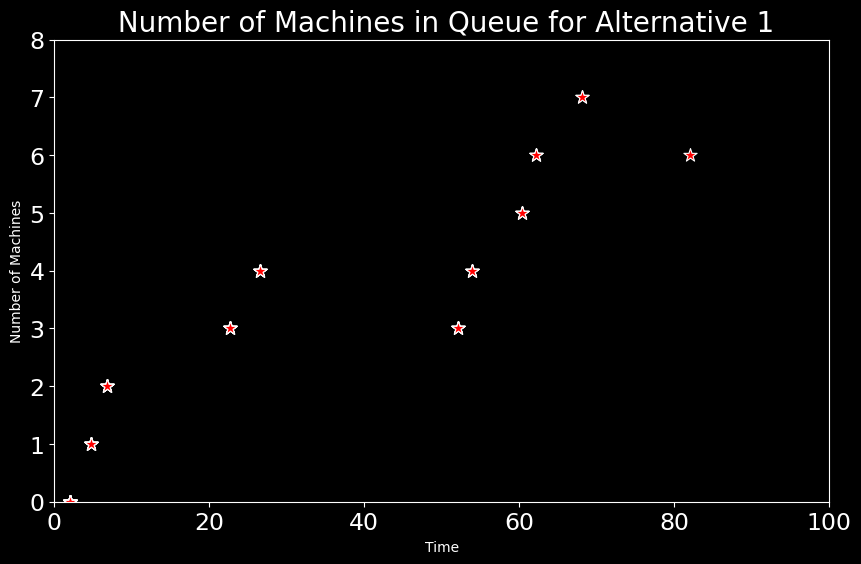

/tmp/ipykernel_328939/270438794.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("failure %3d occurs at %.2f" % (failure_number, env.now))
/tmp/ipykernel_328939/270438794.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%3d enters the queue at %.2f" % (failure_number, queue_in))
/tmp/ipykernel_328939/270438794.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%3d leaves the queue at %.2f" % (failure_number, queue_out))


failure   1 occurs at 21.79
  1 enters the queue at 21.79
  1 leaves the queue at 21.79
[0.45971693]
failure   2 occurs at 27.67
  2 enters the queue at 27.67
  2 leaves the queue at 27.67
[0.33109475]
failure   3 occurs at 52.41
  3 enters the queue at 52.41
failure   4 occurs at 57.03
  4 enters the queue at 57.03
  2 stays at service 30.00
  3 leaves the queue at 57.67
[0.76714044]
  1 stays at service 40.00
  4 leaves the queue at 61.79
[0.40850381]
failure   5 occurs at 85.19
  5 enters the queue at 85.19
failure   6 occurs at 88.16
  6 enters the queue at 88.16
failure   7 occurs at 93.80
  7 enters the queue at 93.80
  3 stays at service 40.00
  5 leaves the queue at 97.67
[0.70555521]
Alternative number: 2
The average delay in queue is 1.75
The average number of machines in queue is 0.47
The average time machines out of system is 38.42
The average time machines were being repaired is 36.67


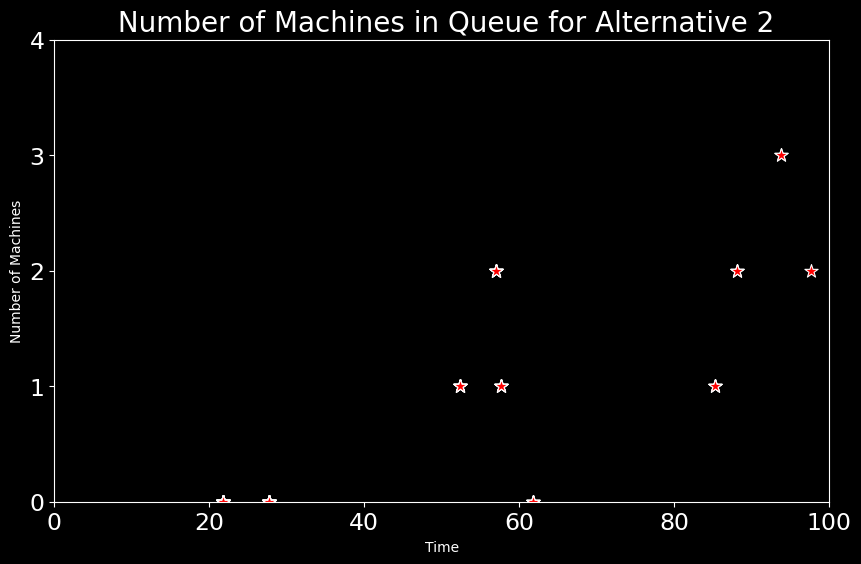

/tmp/ipykernel_328939/270438794.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("failure %3d occurs at %.2f" % (failure_number, env.now))
/tmp/ipykernel_328939/270438794.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%3d enters the queue at %.2f" % (failure_number, queue_in))
/tmp/ipykernel_328939/270438794.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%3d leaves the queue at %.2f" % (failure_number, queue_out))


failure   1 occurs at 13.08
  1 enters the queue at 13.08
  1 leaves the queue at 13.08
[0.31514704]
failure   2 occurs at 21.28
  2 enters the queue at 21.28
  2 leaves the queue at 21.28
[0.44067028]
failure   3 occurs at 25.60
  3 enters the queue at 25.60
  3 leaves the queue at 25.60
[0.26009226]
failure   4 occurs at 31.79
  4 enters the queue at 31.79
failure   5 occurs at 42.69
  5 enters the queue at 42.69
  1 stays at service 30.00
  4 leaves the queue at 43.08
[0.7318591]
failure   6 occurs at 43.31
  6 enters the queue at 43.31
failure   7 occurs at 52.61
  7 enters the queue at 52.61
  3 stays at service 30.00
  5 leaves the queue at 55.60
[0.98774996]
  2 stays at service 40.00
  6 leaves the queue at 61.28
[0.28626306]
failure   8 occurs at 63.59
  8 enters the queue at 63.59
failure   9 occurs at 69.64
  9 enters the queue at 69.64
failure  10 occurs at 70.99
 10 enters the queue at 70.99
  4 stays at service 40.00
  7 leaves the queue at 83.08
[0.72269611]
failure  11 

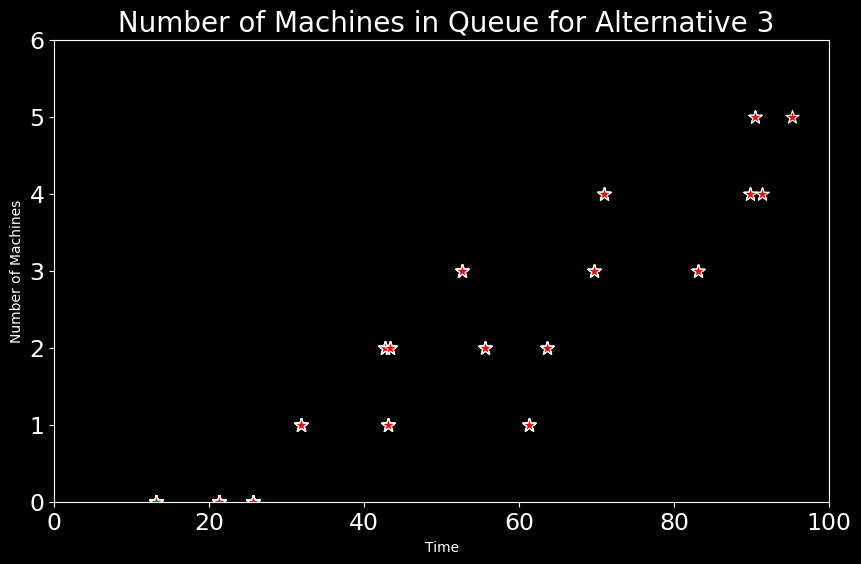

/tmp/ipykernel_328939/270438794.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("failure %3d occurs at %.2f" % (failure_number, env.now))
/tmp/ipykernel_328939/270438794.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%3d enters the queue at %.2f" % (failure_number, queue_in))
/tmp/ipykernel_328939/270438794.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%3d leaves the queue at %.2f" % (failure_number, queue_out))


failure   1 occurs at 2.51
  1 enters the queue at 2.51
  1 leaves the queue at 2.51
[0.27781276]
failure   2 occurs at 2.52
  2 enters the queue at 2.52
  2 leaves the queue at 2.52
[0.4930997]
failure   3 occurs at 5.45
  3 enters the queue at 5.45
  3 leaves the queue at 5.45
[0.08692106]
failure   4 occurs at 13.49
  4 enters the queue at 13.49
  4 leaves the queue at 13.49
[0.48445001]
  3 stays at service 15.00
  1 stays at service 30.00
failure   5 occurs at 41.71
  5 enters the queue at 41.71
  5 leaves the queue at 41.71
[0.48085253]
  2 stays at service 40.00
failure   6 occurs at 49.83
  6 enters the queue at 49.83
  6 leaves the queue at 49.83
[0.46697358]
failure   7 occurs at 50.41
  7 enters the queue at 50.41
  7 leaves the queue at 50.41
[0.32455134]
  4 stays at service 40.00
failure   8 occurs at 61.92
  8 enters the queue at 61.92
  8 leaves the queue at 61.92
[0.2712492]
failure   9 occurs at 68.96
  9 enters the queue at 68.96
  7 stays at service 30.00
  9 leaves

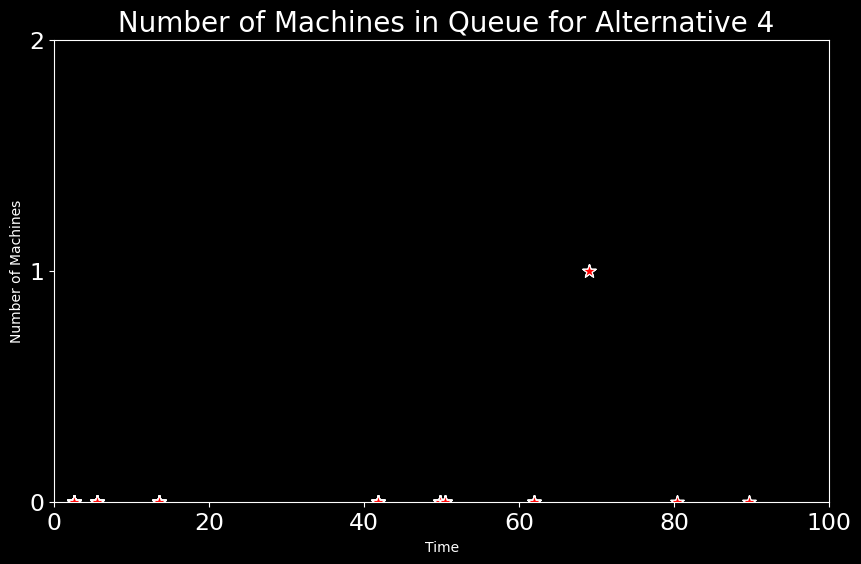

/tmp/ipykernel_328939/270438794.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("failure %3d occurs at %.2f" % (failure_number, env.now))
/tmp/ipykernel_328939/270438794.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%3d enters the queue at %.2f" % (failure_number, queue_in))
/tmp/ipykernel_328939/270438794.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%3d leaves the queue at %.2f" % (failure_number, queue_out))


failure   1 occurs at 38.32
  1 enters the queue at 38.32
  1 leaves the queue at 38.32
[0.75447035]
failure   2 occurs at 52.73
  2 enters the queue at 52.73
  2 leaves the queue at 52.73
[0.24121531]
failure   3 occurs at 54.80
  3 enters the queue at 54.80
  3 leaves the queue at 54.80
[0.66707679]
failure   4 occurs at 55.75
  4 enters the queue at 55.75
  4 leaves the queue at 55.75
[0.2453683]
failure   5 occurs at 57.79
  5 enters the queue at 57.79
  5 leaves the queue at 57.79
[0.4331862]
failure   6 occurs at 64.56
  6 enters the queue at 64.56
failure   7 occurs at 66.52
  7 enters the queue at 66.52
failure   8 occurs at 70.54
  8 enters the queue at 70.54
  1 stays at service 40.00
  6 leaves the queue at 78.32
[0.50516972]
  2 stays at service 30.00
  7 leaves the queue at 82.73
[0.36248431]
failure   9 occurs at 84.43
  9 enters the queue at 84.43
failure  10 occurs at 84.78
 10 enters the queue at 84.78
  4 stays at service 30.00
  8 leaves the queue at 85.75
[0.9783907

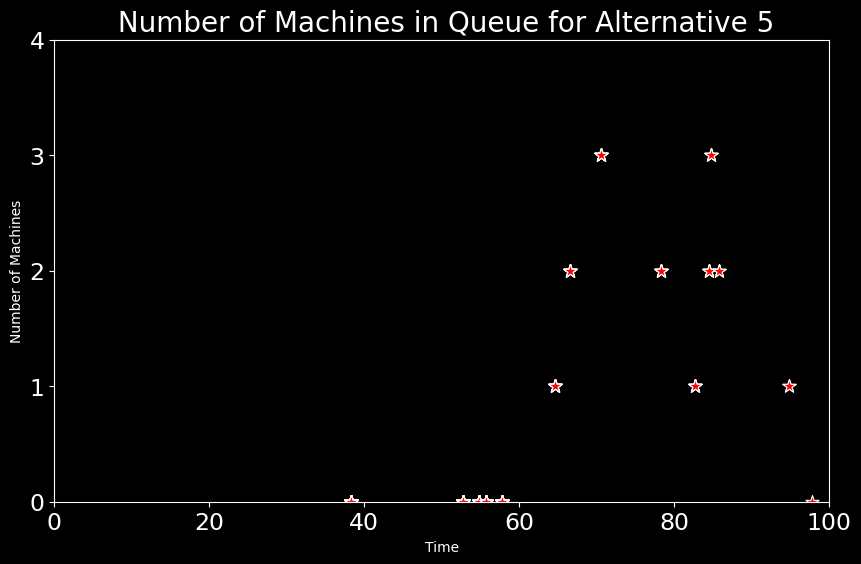

In [6]:
RANDOM_SEEDS = [1234, 5678, 9012, 3456, 7890]

np.random.seed(seed=RANDOM_SEEDS[4])

for altern in range(5):
    failures, repaired = [], []
    in_queue, in_service = [], []
    out_system = []
    tme_in_queue, len_in_queue = [], []

    env = simpy.Environment()

    NUMBER_REPAIR_PERSONS = altern + 1
    repair_persons = simpy.Resource(env, capacity=NUMBER_REPAIR_PERSONS)

    env.process(machine_failure(env, repair_persons))
    env.run(until=SIM_TIME)
    
    calc_averages()

Finally, a table resumes the measures of performance to quantify their corresponding costs.

In [7]:
##..................................................................
def print_averages():
    round_avg_delay = [round(num, 2) for num in avg_delay]
    round_avg_length = [round(num, 2) for num in avg_length]
    round_avg_out_system = [round(num, 2) for num in avg_out_system]
    round_avg_in_service = [round(num, 2) for num in avg_in_service]

    listoflists = []
    listoflists.append(round_avg_delay)
    listoflists.append(round_avg_length)
    listoflists.append(round_avg_out_system)
    listoflists.append(round_avg_in_service)

    fig, ax = plt.subplots(1, 1)
    column_labels = [" Alt. 1", " Alt. 2", " Alt. 3", " Alt. 4", " Alt. 5"]
    row_labels = [
        "Avg. delay in queue",
        "Avg. number of machines in queue",
        "Avg. time machines out of system",
        "Avg. time in repair",
    ]
    df = pd.DataFrame(listoflists, columns=column_labels)

    ax.axis("tight")
    ax.axis("off")
    ax.table(
        cellText=df.values,
        cellColours=[["red"] * 5] * 4,
        colLabels=df.columns,
        rowLabels=row_labels,
        rowColours=["skyblue"] * 4,
        colColours=["cyan"] * 5,
        loc="center",
    )
    ax.set_title("Measures of Performance", fontsize=18, y=0.8, pad=4)
    plt.savefig(abspath("perf_measures.png"), bbox_inches="tight", dpi=150)
    plt.show()

In [ ]:
print_averages()

## Analysis

The following screenshot shows the values of the measures of performance after one simulation run with the seed value 5678 for the third alternative (3 repairmen):

![](perf_measures_5678.png)

The following chart shows the evolution of the number of machines awaiting repair for the same alternative:

It seems that the management should choose to hire two repairmen (alternative 2) as the best solution.


But this simulation study has two serious drawbacks:

1) The choice of 100 as the final simulation time was completely arbitrary. However, the length of the simulation run varies according to the type of system to be studied and the performance measures to be quantified.

2) The results obtained depended strongly on the sequence of random numbers used in that simulation run. If we change the seed value and use the second element of the RANDOM_SEEDS list (9012), we obtain the following summary table:

![](perf_measures_9012.png)

We only changed the seed value and the estimates of some measures of performance changed significantly. The reason for this is that they are particular realizations of random variables that may have larger variances.

We will indicate ways to solve these serious drawbacks in the following articles.